In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

/Users/dc/DeepLearning/udacity_dl/deep-learning/tv-script-generation
Computing spectral radius...
done.
MSE = 8.22818096477e-06


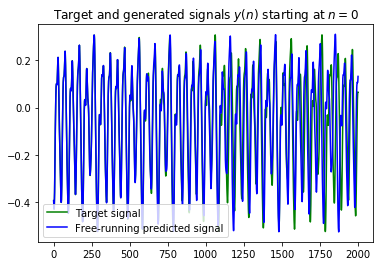

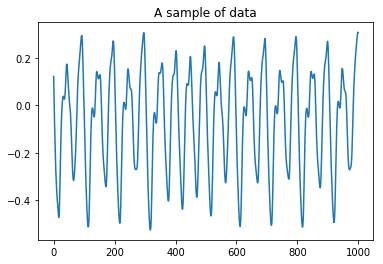

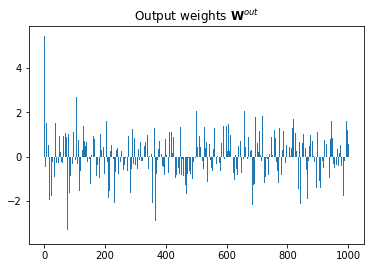

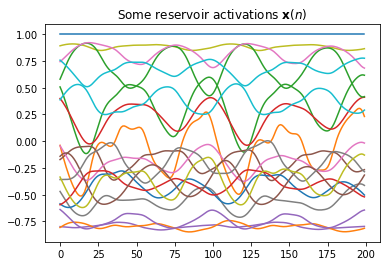

In [10]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

# load the data
trainLen = 2000
testLen = 2000
initLen = 100
import os
print(os.getcwd())
data = loadtxt('MackeyGlass_t17.txt')

# plot some of it
figure(10).clear()
plot(data[0:1000])
title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate

random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
W = random.rand(resSize,resSize)-0.5 
# Option 1 - direct scaling (quick&dirty, reservoir-specific):
#W *= 0.135 
# Option 2 - normalizing and setting spectral radius (correct, slow):
print ('Computing spectral radius...',)
rhoW = max(abs(linalg.eig(W)[0]))
print ('done.')
W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]
    
# train the output
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
    reg*eye(1+inSize+resSize) ) )
#Wout = dot( Yt, linalg.pinv(X) )

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print ('MSE = ' + str( mse ))
    
# plot some signals
figure(1).clear()
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])

figure(2).clear()
plot( X[0:20,0:200].T )
title('Some reservoir activations $\mathbf{x}(n)$')

figure(3).clear()
bar( range(1+inSize+resSize), Wout.T )
title('Output weights $\mathbf{W}^{out}$')

show()